At first, you need to update the torch version:

In [1]:
!pip uninstall --y torch torchvision
!pip install --pre torchvision -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html

Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
Found existing installation: torchvision 0.19.1+cu121
Uninstalling torchvision-0.19.1+cu121:
  Successfully uninstalled torchvision-0.19.1+cu121
Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━

After running previous code - restart yout runtime to finish instalation.

In [18]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
os.chdir("/content/gdrive/My Drive/Assignment4_GAN/Startpkg_A4_P1")

Mounted at /content/gdrive


# Generative Adversarial Networks

For this part of the assignment you implement two different types of generative adversarial networks. We will train the networks on the Stanford cars dataset which is a large set of cars images.

In [19]:
import os
os.environ["OMP_NUM_THREADS"]="3"

In [20]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# GAN loss functions

In this assignment you will implement two different types of GAN cost functions. You will first implement the loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). You will also implement the loss from [LS-GAN](https://arxiv.org/abs/1611.04076).

### GAN loss

**TODO:** Implement the `discriminator_loss` and `generator_loss` functions in `gan/losses.py`.

The generator loss is given by:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [23]:
from gan.losses import discriminator_loss, generator_loss

### Least Squares GAN loss

**TODO:** Implement the `ls_discriminator_loss` and `ls_generator_loss` functions in `gan/losses.py`.

We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [24]:
from gan.losses import ls_discriminator_loss, ls_generator_loss

# GAN model architecture

**TODO:** Implement the `Discriminator` and `Generator` networks in `gan/models.py`.

We recommend the following architectures which are inspired by [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):

**Discriminator:**

- convolutional layer with in_channels=3, out_channels=128, kernel=4, stride=2
- convolutional layer with in_channels=128, out_channels=256, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=256, out_channels=512, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=512, out_channels=1024, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=1024, out_channels=1, kernel=4, stride=1

Instead of Relu we LeakyReLu throughout the discriminator (we use a negative slope value of 0.2).

The output of your discriminator should be a single value score corresponding to each input sample. See `torch.nn.LeakyReLU`.


**Generator:**

**Note:** In the generator, you will need to use transposed convolution (sometimes known as fractionally-strided convolution or deconvolution). This function is implemented in pytorch as `torch.nn.ConvTranspose2d`.

- transpose convolution with in_channels=NOISE_DIM, out_channels=1024, kernel=4, stride=1
- batch norm
- transpose convolution with in_channels=1024, out_channels=512, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=512, out_channels=256, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=256, out_channels=128, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=128, out_channels=3, kernel=4, stride=2

The output of the final layer of the generator network should have a `tanh` nonlinearity to output values between -1 and 1. The output should be a 3x64x64 tensor for each sample (equal dimensions to the images from the dataset).





In [29]:
from gan.models import Discriminator, Generator

# Data loading: Stanford Cars dataset



In [30]:
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /content/gdrive/My Drive/Assignment4_GAN/Startpkg_A4_P1


In [27]:
batch_size = 128
scale_size = (64, 64)

#stanfordcar_train = torchvision.datasets.StanfordCars(root="./", download=False, transform=transforms.Compose([transforms.Resize(scale_size), transforms.ToTensor()]))
stanfordcar_train = torchvision.datasets.StanfordCars(root="./", download=False, transform=transforms.Compose([transforms.Resize(scale_size), transforms.ToTensor()]))

stanfordcar_loader_train = DataLoader(stanfordcar_train, batch_size=batch_size, drop_last=True)

detailer = iter(stanfordcar_loader_train)



### Visualize dataset

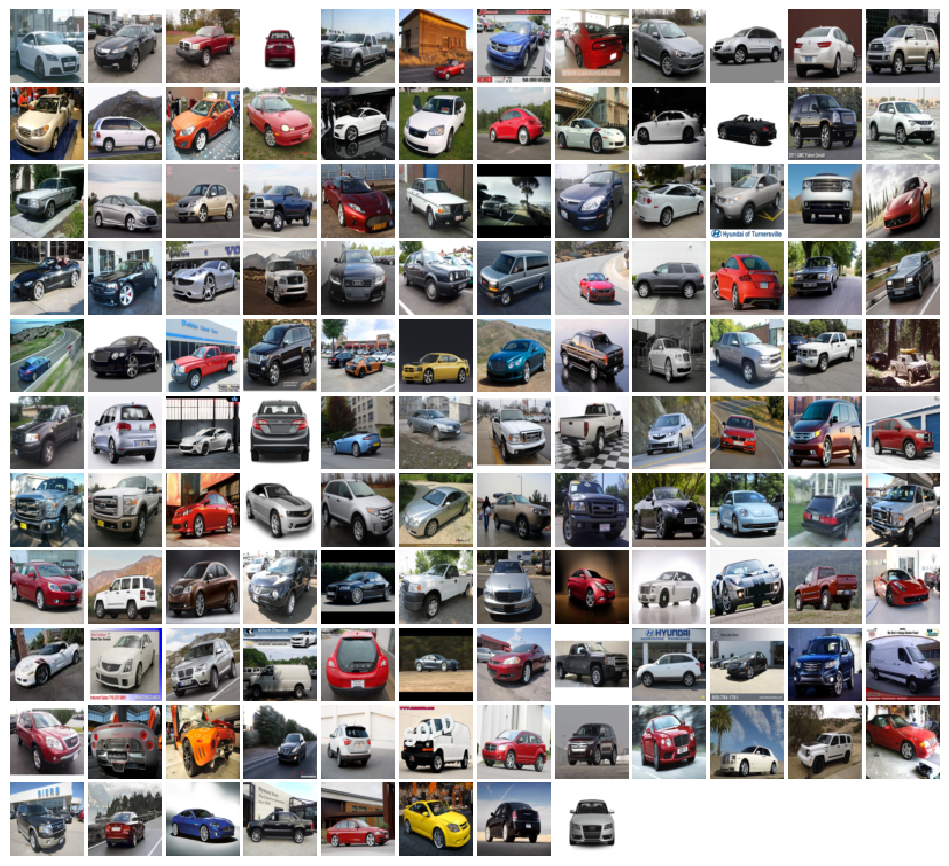

In [28]:
imgs = next(detailer)[0].numpy().squeeze()
show_images(imgs, color=True)

# Training


**TODO:** Fill in the training loop in `gan/train.py`.

In [35]:
NOISE_DIM = 100
NUM_EPOCHS = 50
learning_rate = 0.0002

### Train GAN

In [36]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [37]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [38]:
# original gan
train(D, G, D_optimizer, G_optimizer, discriminator_loss,
          generator_loss, num_epochs=NUM_EPOCHS, show_every=50,
          train_loader=stanfordcar_loader_train, device=device)


EPOCH:  1


KeyboardInterrupt: 

### Train LS-GAN

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [ ]:
# ls-gan
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss,
          ls_generator_loss, num_epochs=NUM_EPOCHS, show_every=50,
          train_loader=stanfordcar_loader_train, device=device)